In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('DataSet_Hitelbiralat_joados.csv')

In [6]:
df.shape

(50000, 32)

In [7]:
df["target"].value_counts()

target
1    40126
0     9874
Name: count, dtype: int64

In [8]:
np.random.seed(42)
df["pred_baseline"] = np.random.rand(df.shape[0])
df["baseline_int"] = df["pred_baseline"] > 0.5

In [9]:
recall_score(df["target"], df["baseline_int"])

0.4992523550814933

In [10]:
roc_auc_score(df["target"], df["baseline_int"])

0.5007908524445344

In [11]:
dummy_cols = ["sex", "marital_status", "residence_type"]

dummy_names = []
for col in dummy_cols:
    dummy_df = pd.get_dummies(df[col], prefix=col, drop_first=True)
    dummy_names = dummy_names + dummy_df.columns.tolist()
    df = pd.concat([df, dummy_df], axis=1)

In [12]:
X_cols = ['age', 'months_in_residence', 'months_in_the_job', 'personal_net_income', 'mate_income']
X_cols = X_cols + dummy_names

In [13]:
X = df.loc[:, X_cols]
y = df["target"]

In [14]:
model = LogisticRegression()
predict_proba = cross_val_predict(model, X, y, cv=4, method="predict_proba")
predict = cross_val_predict(model, X, y, cv=4)

In [15]:
df["pred_lr"] = predict
df["pred_lr"].value_counts()

pred_lr
1    49999
0        1
Name: count, dtype: int64

In [16]:
confusion_matrix(df["target"], df["pred_lr"])

array([[    0,  9874],
       [    1, 40125]])

In [17]:
roc_auc_score(df["target"], df["pred_lr"])

0.49998753925135825

In [18]:
df["pred_lr_proba"] = predict_proba[:, 1]

In [19]:
roc_auc_score(df["target"], df["pred_lr_proba"])

0.6208329017796897

In [21]:
model = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [27]:
accuracy_score(y_train, y_pred_train)

0.9899428571428571

In [28]:
accuracy_score(y_test, y_pred_test)

0.6892666666666667

In [29]:
from tqdm import tqdm

score_list_train = []
score_list_test = []
for i in tqdm(range(1, 31)):
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    score_train = accuracy_score(y_train, y_pred_train)
    score_test = accuracy_score(y_test, y_pred_test)

    score_list_train.append(score_train)
    score_list_test.append(score_test)

100%|██████████| 30/30 [00:02<00:00, 10.47it/s]


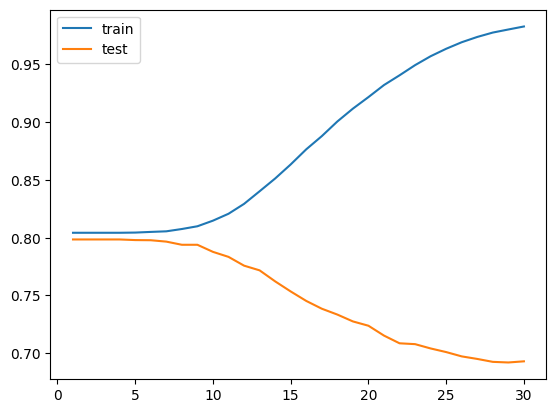

In [31]:
plt.plot(range(1, 31), score_list_train, label="train")
plt.plot(range(1, 31), score_list_test, label="test")
plt.legend()

In [34]:
model = KNeighborsClassifier(n_neighbors=5)
scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [35]:
pipeline = Pipeline(steps=[("scaler", scaler), ("knn", model)])

In [36]:
predict_proba = cross_val_predict(pipeline, X, y, cv=4, method="predict_proba")
df["pred_knn_proba"] = predict_proba[:, 1]

In [37]:
df["profit"] = df["target"].apply(lambda x: 15000 if x == 1 else -10000)

<Axes: >

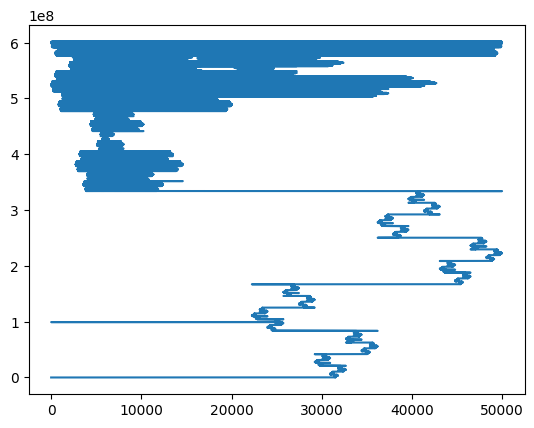

In [38]:
df.sort_values("target", ascending=False)["profit"].cumsum().reindex(drop=True).plot()